<a href="https://colab.research.google.com/github/TOM-BOHN/MsDS-marketing-text-classification/blob/main/marketing_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Marketing Text Classification
**Thomas Bohn**   --   **2023-09-13**

A report focused on modeling news article categorization for marketing analytics. This notebook focuses on the application of natural language processing, supervised learning with [k-train](https://github.com/amaiya/ktrain) (a wrapper for [Tensorflow](https://www.tensorflow.org/api_docs/python/tf/all_symbols), [Keras](https://keras.io/getting_started/), and [Huggingface Transformers](https://github.com/huggingface/transformers)), and a evaluation of performance.

--  [Main Report](https://github.com/TOM-BOHN/Customer-Success-Scorecards/blob/main/marketing_text_classification.ipynb)  --  [Github Repo](https://github.com/TOM-BOHN/MsDS-marketing-text-classification)  --  [Presentation Slides](https://docs.google.com/presentation/d/1BZGyeEuisYugheSnQGIpPwpbeDQ205HmnHk6fI6f2y8/edit?usp=sharing)  --  [Presentation Video](https://drive.google.com/file/d/119AgwtaeVw9ibV1rTfRauN-ADw_BREFH/view?usp=sharing) --

# 1.&nbsp;Introduction

**Context**
A media buying company has acquired a new customer [Theragun](https://www.therabody.com/us/en-us/4th-generation-devices/), a company developing wellness products backed by science and developed by medical experts. Theragun knows that consumers who value health and wellness are more likely to consider, and ultimately buy their product. They have requested their media buying company partner identify as many news articles around the web that mention health and wellness. Their goal is to feature advertisements on these pages to reach as many customers as possible.

**Background**
Text and text documents are one of the richest sources of data for businesses. They are websites, pdfs, news articles, etc. A strategy utilized by marketing firms is contextual advertising. It focused on using marketing analytics to find URLs that match the context required to target an advertisement to potential customers. The main challenge is to build an algorithm that successfully predicts the probability that a website is related to the desired context. The final trained model can be used to identify tags for untracked websites or to identify the type of language used in different websites.

**Data Source**
The dataset contains around 200k news headlines from the year 2012 to 2018 obtained from [HuffPost](https://www.huffpost.com/). It can be sourced [here](https://drive.google.com/file/d/1jnucfZWLPmxG4UzPtgd-dRe_Z9tPo60V/view?usp=sharing).

**Categories**
Each news headline has a corresponding category. The articles are labeled under one of ??? categories. A sample of the categories is as follows:
- WELLNESS: 17827
- HEALTHY LIVING: 6694
- ...
- POLITICS: 32739
- TECH: 2082

**Overview of Observations**
The dataset is 200k records that will need to be broken into training data and test data. Each observation is the headline text, short description, and category of an article with an associated article id.

**Objective**
The objective is to build a deep learning algorithm that predicts the probability that a news story is about health and wellness. Final evaluation will use Sensativity (also known as "Recall") to maximize the number of targeted news articles. Sensativity is the percent of cases where the model prediction is correct, when the actual value is positive.

**Report Overview**
The project will cover 5 key phases:
1. Exploratory Data Analysis (EDA)
2. Data Cleaning
3. Extracting Word Features with Natural Language Processing (NLP) Tools
4. Building and Training an Unsupervised Non-Negative Matrix Factorization (NMF) Model
5. Build and Compare a Random Forest Supervised Learning Model

## Python Libraries

The following python libraries are used in this notebook.

In [1]:
# File Connection and File Manipulation
import os
import time
import pickle
import json
import glob
# Basic Data Science Toolkits
import pandas as pd
import numpy as np
import math
import time
# Basic Data Vizualization
import seaborn as sns
import matplotlib.pyplot as plt
# Import Data Model Evaluations
from sklearn.model_selection import train_test_split
from sklearn import metrics
# NLP Tokenizer
from keras.preprocessing.text import Tokenizer
# Google's Tensorflow package
# https://www.tensorflow.org/tutorials
import tensorflow as tf
print(tf.__version__)
# API wrapper for Tensorflow called ktrain
# https://github.com/amaiya/ktrain
try:
  import ktrain
except:
  !pip install ktrain
  os.kill(os.getpid(), 9)
from ktrain import text
from ktrain.text import texts_from_df
#NLP Text Cleanup
import re
import nltk
import nltk.corpus
from nltk.corpus import stopwords

# NLP Tokenizer and Lemmatizer
import nltk
import nltk.corpus
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from string import digits

2.13.0


## Installing NLTK Data

In [2]:
#Install the necessary datasets/models for specific functions to work
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('brown')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
# Test to confirm the download worked
from nltk.corpus import brown
brown.words()
#dir(nltk)

['The', 'Fulton', 'County', 'Grand', 'Jury', 'said', ...]

## Verify GPU Runtime

In [4]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Sep 13 15:21:24 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    24W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


## Mount Google Drive

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Setup Directories

In [7]:
ROOT_DIR = "/content/drive/MyDrive/MSDS_marketing_text_analytics/master_files/1_text_classification"
DATA_DIR = "%s/data" % ROOT_DIR
EVAL_DIR = "%s/evaluation" % ROOT_DIR
MODEL_DIR = "%s/models" % ROOT_DIR

#Create missing directories, if they don't exist
if not os.path.exists(DATA_DIR):
  # Create a new directory because it does not exist
  os.makedirs(DATA_DIR)
  print("The data directory is created!")
if not os.path.exists(EVAL_DIR):
  # Create a new directory because it does not exist
  os.makedirs(EVAL_DIR)
  print("The evaluation directory is created!")
if not os.path.exists(MODEL_DIR):
  # Create a new directory because it does not exist
  os.makedirs(MODEL_DIR)
  print("The model directory is created!")

# 2.&nbsp;Data Source

## Copy Data From Source

In [8]:
#!wget <URL> -P <COLAB PATH>
source_url = 'https://docs.google.com/uc?export=download&id=1jnucfZWLPmxG4UzPtgd-dRe_Z9tPo60V'
dest_url = "%s/news_category_trainingdata.json" % DATA_DIR
!wget -O "$file_name" "$source_url" -O "$dest_url"

No such file or directory


## Load the Data

In [9]:
# Read the data into a datframe
df_news = pd.read_json(dest_url)

In [10]:
# Merge two text column for the model
df_news['combined_text'] = df_news['headline'] + ' ' + df_news['short_description']
# Create a flag of welness related articles
cat_list_wellness = ['HEALTHY LIVING', 'WELLNESS']
df_news['wellness'] = np.where((df_news['category'].isin(cat_list_wellness)), 1, 0)

In [11]:
# Preview the new dataframe
df_news.head()

,category,headline,authors,link,short_description,date,combined_text,wellness
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26,There Were 2 Mass Shootings In Texas Last Week...,0
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26,Will Smith Joins Diplo And Nicky Jam For The 2...,0
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26,Hugh Grant Marries For The First Time At Age 5...,0
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,0
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26,Julianna Margulies Uses Donald Trump Poop Bags...,0


# 3.&nbsp;Exploratory Data Analysis (EDA)

## Review the Content of One Observation

In [12]:
# show the content of one Article in the data source
idx = 0
print('category:', df_news['category'][idx], '\t wellness:', df_news['wellness'][idx],'\n')
print('headline:', df_news['headline'][idx], '\n')
print('short_description:', df_news['short_description'][idx], '\n')
print('combined_text:', df_news['combined_text'][idx], '\n')

category: CRIME 	 wellness: 0 

headline: There Were 2 Mass Shootings In Texas Last Week, But Only 1 On TV 

short_description: She left her husband. He killed their children. Just another day in America. 

combined_text: There Were 2 Mass Shootings In Texas Last Week, But Only 1 On TV She left her husband. He killed their children. Just another day in America. 



## Review the Distribution of Categories

In [13]:
# Create a summary of the categories
df_cat_count = pd.DataFrame(df_news['category'].value_counts()).reset_index()
df_cat_count.reset_index()
df_cat_count.columns = ['category', 'count']
# Derive Stats vand Lists
cat_list = list(df_cat_count['category'].unique())
cat_list_wellness = ['HEALTHY LIVING', 'WELLNESS']
cat_list_not_wellness = list(set(cat_list) - set(cat_list_wellness))
total_categories = len(cat_list)
total_wellness_cats = len(cat_list_wellness)
total_not_wellness_cats = len(cat_list_not_wellness)
# Print a Summary
print('Total Categories:', total_categories)
print('Wellness Categories:', total_wellness_cats, '\n\tList:', cat_list_wellness)
print('Non-Wellness Categories:', total_not_wellness_cats, '\n\tList:', cat_list_not_wellness)

Total Categories: 41
Wellness Categories: 2 
	List: ['HEALTHY LIVING', 'WELLNESS']
Non-Wellness Categories: 39 
	List: ['BUSINESS', 'GOOD NEWS', 'WORLD NEWS', 'TASTE', 'COMEDY', 'FIFTY', 'STYLE', 'ARTS', 'HOME & LIVING', 'MONEY', 'STYLE & BEAUTY', 'CULTURE & ARTS', 'ENTERTAINMENT', 'WOMEN', 'LATINO VOICES', 'TRAVEL', 'TECH', 'PARENTS', 'GREEN', 'MEDIA', 'SPORTS', 'PARENTING', 'WORLDPOST', 'BLACK VOICES', 'QUEER VOICES', 'SCIENCE', 'DIVORCE', 'IMPACT', 'CRIME', 'ENVIRONMENT', 'WEIRD NEWS', 'EDUCATION', 'FOOD & DRINK', 'THE WORLDPOST', 'ARTS & CULTURE', 'RELIGION', 'COLLEGE', 'WEDDINGS', 'POLITICS']


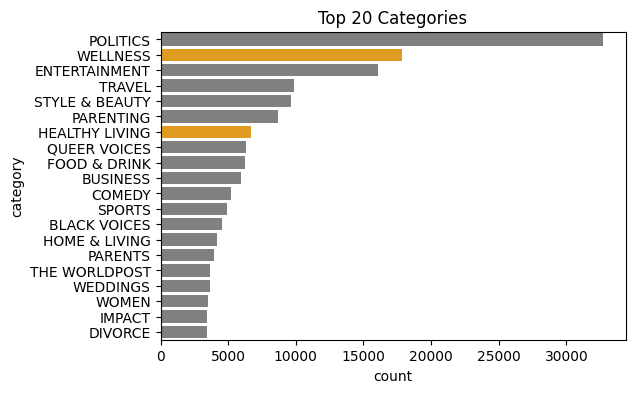

In [14]:
# Create a summary bar chart of categories
f = plt.figure(figsize=(6,4))
cols = ['orange' if (y in ['WELLNESS', 'HEALTHY LIVING']) else 'grey' for y in df_cat_count['category']]
sns.barplot(x = 'count',
            y = 'category',
            data = df_cat_count.head(20),
            palette=cols
            ).set(title='Top 20 Categories',)
plt.show()

In [15]:
# Preview the Split of Data
df_news['wellness'].value_counts()

0    176332
1     24521
Name: wellness, dtype: int64

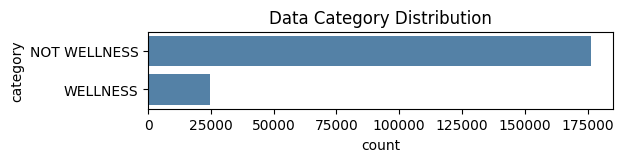

In [16]:
# Create a summary of the categories
df_wellness_count = pd.DataFrame(df_news['wellness'].value_counts()).reset_index()
df_wellness_count.columns = ['category', 'count']
dict_target_names = {0: 'NOT WELLNESS', 1: 'WELLNESS'}
df_wellness_count['category'].replace(dict_target_names, inplace=True)
# Create a summary bar chart of categories
f = plt.figure(figsize=(6,1))
sns.barplot(x = 'count',
            y = 'category',
            data = df_wellness_count,
            color = 'steelblue'
            ).set(title='Data Category Distribution',)
plt.show()

The categories are unevenly distributed across the categories. To ensure a proper mix of articles from each category, a stratified sample should be conducted to maintain the distribution, but scale down the volume of records. An equal number of wellness and non-wellness articles should be included in the sampled data.

## Review of the Text

Text(0, 0.5, 'Record Count')

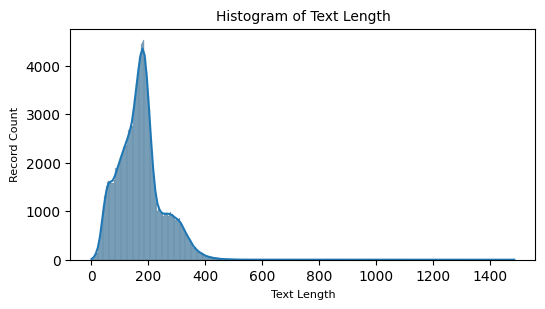

In [17]:
# add a length column to the dataframe
df_news['text_length'] = df_news['combined_text'].apply(len)
#create a figure
fig, ax = plt.subplots(figsize = (6,3))
# create a histogram of the length of text
#chart = plt.hist(x = df_s['Text Length'])
chart = sns.histplot(x = df_news['text_length'], kde=True)
# Customising legend
ax.set_title('Histogram of Text Length', fontsize=10)
ax.set_xlabel('Text Length', fontsize=8)
ax.set_ylabel('Record Count', fontsize=8)

Text(0.5, 1.0, 'Boxplot of Text Length')

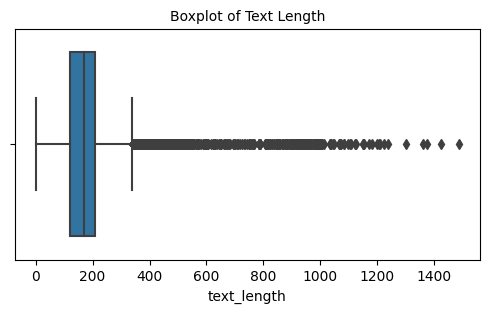

In [18]:
#create a figure
fig, ax = plt.subplots(figsize = (6,3))
# create a boxplot of the length of text
chart = sns.boxplot(x = df_news['text_length'])
ax.set_title('Boxplot of Text Length', fontsize=10)

Text(0.5, 1.0, 'Boxplot of Word Count')

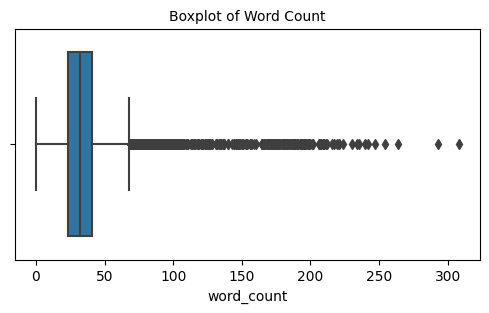

In [19]:
# define a function to add the word count to a dataframe
def add_word_count(df):
    df['text_token'] = df.apply(lambda row: nltk.word_tokenize(row['combined_text']), axis=1)
    df['word_count'] = df['text_token'].apply(len)
    df.drop(columns = ['text_token'], inplace=True)
    return df
# add a length column to the dataframe for wordcount
df_news = add_word_count(df = df_news)
#create a figure
fig, ax = plt.subplots(figsize = (6,3))
# create a boxplot of the length of text
chart = sns.boxplot(x = df_news['word_count'])
ax.set_title('Boxplot of Word Count', fontsize=10)

# 4.&nbsp;Data Cleansing

## Check for Nulls and Remove

In [20]:
# Identify Columns with Nulls
def identify_columns_with_null(df):
  a = [np.nan, None, [], {}, 'NaN', 'Null','NULL','None','NA','?','-', '.','', ' ', '   ']
  nc = {}

  for c in df.columns:
      string_null = np.array([x in a[2:] for x in df[c]]).sum()
      std_null = df[c].isnull().sum()
      ttl_null = std_null + string_null
      if ttl_null > 0:
          nc[c] = ttl_null

  print('number of fields with nulls:', len(nc), '\n')
  print(pd.Series(nc))

  return nc

In [21]:
# Detect Columns with null values
null_columns = identify_columns_with_null(df = df_news)

number of fields with nulls: 4 

headline                 6
authors              36620
short_description    19712
combined_text            5
dtype: int64


In [22]:
df_news['combined_text'].replace('', np.nan, inplace=True)
df_news['headline'].replace('', np.nan, inplace=True)
df_news.dropna(subset=['combined_text'], inplace=True)
df_news.dropna(subset=['headline'], inplace=True)
null_columns = identify_columns_with_null(df = df_news)

number of fields with nulls: 2 

authors              36620
short_description    19707
dtype: int64


## Clean Text for Modeling

In [23]:
# Create a funtion to clean a dataframe with text
def clean_text(df, text_col):
    # removes punctuation
    df['no_punct'] = df[text_col].apply(
        lambda row: re.sub(r'[^\w\s]+', '', row))
    # removes numbers
    df['no_punct_num'] = df['no_punct'].apply(
        lambda row: re.sub(r'[0-9]+', '', row))
    # removes stop words, e.g. a, an, and, but, in, on, the...
    stop_words = stopwords.words('english')
    df['no_stopwords'] = df['no_punct_num'].apply(
        lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
    # removes extra spaces
    df['clean_text'] = df['no_stopwords'].apply(
        lambda x: re.sub(' +', ' ', x))
    # tidy the table
    df.drop(columns = ['no_punct','no_punct_num','no_stopwords'], inplace=True)
    return

In [24]:
# Tokenize text functions
wordnet_lemmatizer = WordNetLemmatizer()
# Function to bulkify lemmatize large block of text one word at a time
def lemmatizer(text):
    lem = [wordnet_lemmatizer.lemmatize(word.lower()) for word in text]
    return lem
# Function to tokenize the entire article then apply the lemmatize to each article
def tokenize_lemmatize(df, text_col):
    df['tokenized_text'] = df.apply(lambda row: nltk.word_tokenize(row[text_col]), axis=1)
    df['lemmatized_text'] = df['tokenized_text'].apply(lambda string: lemmatizer(string))
    return

In [25]:
# will not use this function as it does not work with LLMs
def deep_clean(df, text_col, preview_idx = 0):
  idx = preview_idx
  # Change the text to lowercase
  df[text_col] = df[text_col].str.lower()
  # Using 'clean_text' function to clean 'Text' column
  clean_text(df = df, text_col = text_col)
  # Preview the changes for the before and after text
  print(df[text_col][idx])
  print('\n## change to ##\n')
  print(df['clean_text'][idx])
  print('\n--------------------\n')
  # Tidy the table
  df[text_col] = df['clean_text']
  df.drop(columns = ['clean_text'], inplace=True)
  # Using text cleaning function to clean the text column
  tokenize_lemmatize(df = df, text_col = text_col)
  # Print a before an after of the tokenization and lematization
  print(df[text_col][idx])
  print('\n## change to ##\n')
  print(df['lemmatized_text'][idx])
  print('\n--------------------\n')
  # Tidy the table
  df[text_col] = df.apply(lambda row: ' '.join(row['lemmatized_text']), axis=1)
  df.drop(columns = ['tokenized_text', 'lemmatized_text'], inplace=True)
  # Print a final preview of the text
  print('## final text ##\n')
  print(df[text_col][idx])

#deep_clean(df = df_news, text_col = 'combined_text', preview_idx = 0)

## Sample and Balance the Data

In [26]:
# Set a sample amount
sample_amount = 20000
# Sample healthy living
healthy = df_news[df_news['wellness'] == 1].sample(n = sample_amount)
# Sample non-healthy living
not_healthy = df_news[df_news['wellness'] == 0]
not_healthy_rows = len(not_healthy)
not_healthy_sample_frac = sample_amount / not_healthy_rows
not_healthy = not_healthy.groupby('category').apply(
    lambda x: x.sample(frac = not_healthy_sample_frac))
not_healthy = not_healthy.droplevel(0)
# Create a Sampled Dataset
df_news_sample = pd.concat([healthy, not_healthy])
# Preview the Split of Data
print(df_news_sample['wellness'].value_counts(), '\n')
# Confirm all categories are represented
sample_cat_list = list(df_news_sample['category'].unique())
total_sample_cats = len(sample_cat_list)
print('Sample Categories:', total_sample_cats, '\n\tList:', sample_cat_list)

1    20000
0    20000
Name: wellness, dtype: int64 

Sample Categories: 41 
	List: ['HEALTHY LIVING', 'WELLNESS', 'ARTS', 'ARTS & CULTURE', 'BLACK VOICES', 'BUSINESS', 'COLLEGE', 'COMEDY', 'CRIME', 'CULTURE & ARTS', 'DIVORCE', 'EDUCATION', 'ENTERTAINMENT', 'ENVIRONMENT', 'FIFTY', 'FOOD & DRINK', 'GOOD NEWS', 'GREEN', 'HOME & LIVING', 'IMPACT', 'LATINO VOICES', 'MEDIA', 'MONEY', 'PARENTING', 'PARENTS', 'POLITICS', 'QUEER VOICES', 'RELIGION', 'SCIENCE', 'SPORTS', 'STYLE', 'STYLE & BEAUTY', 'TASTE', 'TECH', 'THE WORLDPOST', 'TRAVEL', 'WEDDINGS', 'WEIRD NEWS', 'WOMEN', 'WORLD NEWS', 'WORLDPOST']


In [27]:
# Create a summary of the categories
df_sample_cat_count = pd.DataFrame(df_news_sample['category'].value_counts()).reset_index()
df_sample_cat_count.reset_index()
df_sample_cat_count.columns = ['category', 'count']

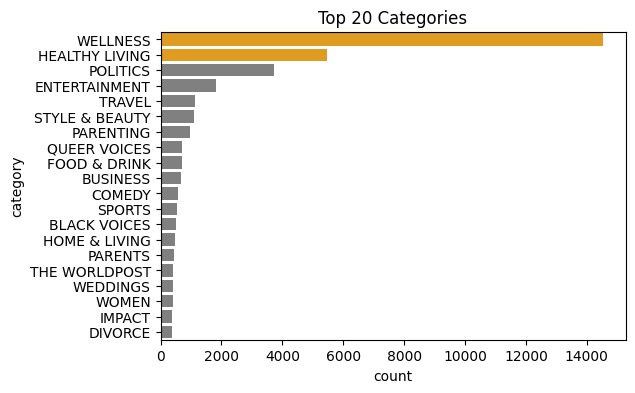

In [28]:
# Create a summary bar chart of categories
cols = ['orange' if (y in ['WELLNESS', 'HEALTHY LIVING']) else 'grey' for y in df_sample_cat_count['category']]
f = plt.figure(figsize=(6,4))
sns.barplot(x = 'count',
            y = 'category',
            data = df_sample_cat_count.head(20),
            palette=cols
            ).set(title='Top 20 Categories')
plt.show()

In [29]:
# Preview the Split of Data
df_news_sample['wellness'].value_counts()

1    20000
0    20000
Name: wellness, dtype: int64

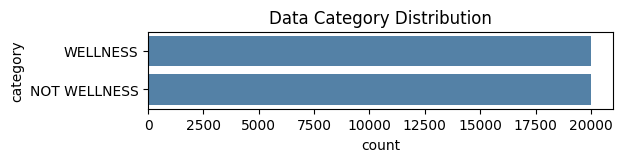

In [30]:
# Create a summary of the categories
df_samp_wellness_count = pd.DataFrame(df_news_sample['wellness'].value_counts()).reset_index()
df_samp_wellness_count.columns = ['category', 'count']
dict_target_names = {0: 'NOT WELLNESS', 1: 'WELLNESS'}
df_samp_wellness_count['category'].replace(dict_target_names, inplace=True)
# Create a summary bar chart of categories
f = plt.figure(figsize=(6,1))
sns.barplot(x = 'count',
            y = 'category',
            data = df_samp_wellness_count,
            color = 'steelblue'
            ).set(title='Data Category Distribution',)
plt.show()

In [31]:
df_news_sample.head(3)

,category,headline,authors,link,short_description,date,combined_text,wellness,text_length,word_count
99534,HEALTHY LIVING,40 Valentine's Day Love Lessons,"Annie Fox, ContributorParenting expert and aut...",https://www.huffingtonpost.com/entry/40-valent...,"In honor of Valentine's Day, I want to share s...",2015-02-05,40 Valentine's Day Love Lessons In honor of Va...,1,230,52
145999,WELLNESS,Silencing the Critic,"Sue Shanahan, Contributor\nAuthor/illustrator",https://www.huffingtonpost.com/entry/critics_u...,Being considerate to others is encouraged. But...,2013-09-05,Silencing the Critic Being considerate to othe...,1,182,30
126345,WELLNESS,8 Reminders That The Best Is Yet To Come,,https://www.huffingtonpost.com/entry/looking-f...,The stress and strain of constantly being conn...,2014-04-03,8 Reminders That The Best Is Yet To Come The s...,1,163,31


# 5.&nbsp;Model: Parameter Tuning

## Create Preprocessed Data with Transformer

In [32]:
target_names = ['NOT WELLNESS','WELLNESS']

In [33]:
# create a transformer to use in the model
tf.keras.backend.clear_session()
t = text.Transformer('distilbert-base-uncased',
                     maxlen = 512,
                     class_names = target_names)
# other models you might try 'roberta-base', 'bert-base-uncased', 'distilroberta-base'
# we're going to use 'distilbert-base-uncased' for our model here
# ktrain lets us try some of the pretrained models available on huggingface
# you can browse all the models here: https://huggingface.co/transformers/pretrained_models.html
# some work, some dont, try at your own risk.

In [34]:
# use the distilbert-base-uncased transformer model
# See all the models here: https://huggingface.co/transformers/pretrained_models.html
train, val, preprocess = texts_from_df(df_news_sample, 'combined_text',
                                       label_columns = ['wellness'],
                                       val_df = None,
                                       max_features = 20000,
                                       maxlen = 512,
                                       val_pct = 0.1,
                                       ngram_range = 1,
                                       preprocess_mode = 'distilbert',
                                       verbose = 1)

['not_wellness', 'wellness']
        not_wellness  wellness
41903            1.0       0.0
194459           0.0       1.0
182078           0.0       1.0
128497           0.0       1.0
136422           1.0       0.0
['not_wellness', 'wellness']
        not_wellness  wellness
39739            1.0       0.0
133095           0.0       1.0
118784           1.0       0.0
128769           0.0       1.0
139299           1.0       0.0
preprocessing train...
language: en
train sequence lengths:
	mean : 32
	95percentile : 58
	99percentile : 68


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 32
	95percentile : 58
	99percentile : 69


## Hyperparameter Tuning : Learning Rate

In [35]:
# create a classifier model
model = preprocess.get_classifier()
# Returns a Learner instance that can be used to tune and train Keras models.
learner = ktrain.get_learner(model,
                             train_data = train,
                             val_data = val,
                             batch_size = 16)

In [36]:
# Simulate training for different learning rates
# Plots loss as learning rate is increased
learner.lr_find(max_epochs = 6)

simulating training for different learning rates... this may take a few moments...
Epoch 1/5
2250/2250 [==============================] - 674s 292ms/step - loss: 0.5057 - accuracy: 0.7304
Epoch 2/5
2250/2250 [==============================] - 662s 292ms/step - loss: 0.2454 - accuracy: 0.9053
Epoch 3/5
2250/2250 [==============================] - 661s 291ms/step - loss: 0.6008 - accuracy: 0.5916
Epoch 4/5
2250/2250 [==============================] - 22s 7ms/step - loss: 1.5893 - accuracy: 0.5162


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


Three possible suggestions for LR from plot:
	Longest valley (red): 4.38E-06
	Min numerical gradient (purple): 3.86E-06
	Min loss divided by 10 (omitted from plot): 2.56E-06


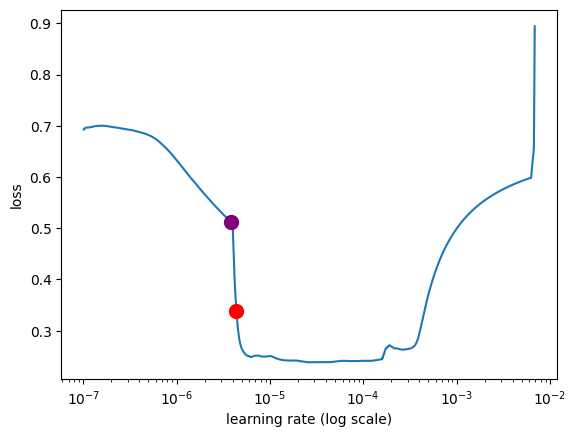

In [37]:
# Plots the loss vs. learning rate to help identify
# The maximal learning rate associated with a falling loss.
learner.lr_plot(suggest = True)

In [38]:
# Return numerical estimates of lr using two different methods:
lr_est = learner.lr_estimate()
print('learning rate (estimate):', lr_est)

learning rate (estimate): (3.8591356e-06, 2.5617348001105713e-06, 4.3848686e-06)


based on the learning rate plot, a learning rate of 10^-4 should be used for the final model.

# 6.&nbsp;Final Model with Ktrain

## Training the Final Model

In [39]:
# Automatically train model with the selected learning rate
history = learner.autofit(
    lr = 3e-5,
    #3e-5 -- value from smaller runs
    #1e-5 -- value from large run and chart above
    #1e-4 -- value from labs,
    checkpoint_folder = 'checkpoint',
    epochs = 12,
    early_stopping = True)



begin training using triangular learning rate policy with max lr of 3e-05...
Epoch 1/12
2250/2250 [==============================] - 685s 298ms/step - loss: 0.2446 - accuracy: 0.9037 - val_loss: 0.1873 - val_accuracy: 0.9290
Epoch 2/12
2250/2250 [==============================] - 669s 297ms/step - loss: 0.1460 - accuracy: 0.9456 - val_loss: 0.1891 - val_accuracy: 0.9300
Epoch 2: early stopping
Weights from best epoch have been loaded into model.


In [40]:
# Save the learner
learner.save_model("%s/distilbertmodel_learner" % DATA_DIR)

In [41]:
# Returns a Predictor instance that can be used to make predictions on unlabeled examples
predictor = ktrain.get_predictor(learner.model, preproc = preprocess)

In [42]:
# Save the predictor model
predictor.save("%s/distilbertmodel_predictor" % DATA_DIR)

## Validate the Model

In [43]:
# Returns confusion matrix and optionally prints a classification report.
validation = learner.validate(val_data = val,
                              print_report = True,
                              class_names = target_names)

125/125 [==============================] - 12s 83ms/step
              precision    recall  f1-score   support

NOT WELLNESS       0.95      0.91      0.93      2023
    WELLNESS       0.91      0.95      0.93      1977

    accuracy                           0.93      4000
   macro avg       0.93      0.93      0.93      4000
weighted avg       0.93      0.93      0.93      4000



# 7.&nbsp; Model Evaluation

## Model Metrics

In [44]:
# Show the data stored in the validation
validation

array([[1846,  177],
       [ 107, 1870]])

In [45]:
# Save confusion matrix and slice into four pieces
TP = validation[1, 1]
TN = validation[0, 0]
FP = validation[0, 1]
FN = validation[1, 0]

In [46]:
# Calculate metrics from confusion matrix
c_accuracy            = (TP + TN) / (TP + TN + FP + FN)
c_error               = (FP + FN) / (TP + TN + FP + FN)
c_sensitivity         = TP / (TP + FN)
c_specificity         = TN / (TN + FP)
c_false_positive_rate = FP / (TN + FP)
c_precision           = TP / (TP + FP)
c_f1                  = (c_sensitivity + c_precision) / 2

In [47]:
# Print a summary of additional metrics
print('Accuracy:\t\t', round(c_accuracy,4)*100, '%')
print('Classification Error:\t', round(c_error,4)*100, '%')
print('Sensitivity / Recall:\t', round(c_sensitivity,4)*100, '%')
print('Specificity:\t\t', round(c_specificity,4)*100, '%')
print('False Positive Rate:\t', round(c_false_positive_rate,4)*100, '%')
print('Precision:\t\t', round(c_precision,4)*100, '%')
print('F1 Score:\t\t', round(c_f1,4)*100, '%')

Accuracy:		 92.9 %
Classification Error:	 7.1 %
Sensitivity / Recall:	 94.59 %
Specificity:		 91.25 %
False Positive Rate:	 8.75 %
Precision:		 91.35 %
F1 Score:		 92.97 %


## Test on Articles Outside Dataset

In [48]:
# Load predictor from save (if needed for analysis)
#predictor = ktrain.load_predictor("%s/distilbertmodel_predictor")
#model = ktrain.get_predictor(predictor.model, predictor.preproc)

In [50]:
# Sample articles to test sourced on 2023-09-12
test_docs = [
'Is swimming in cold water good for you? Cold water exposure has arousing and stimulating effects, and it appears to increase many substances that we know are involved in regulating mood.',
'For jet lag, a hearty breakfast in the new time zone may help Eating an early meal in the new time zone and avoiding a meal late the night before could mean two fewer days of jet lag, a mathematical model showed.',

'Overdoses soared even as prescription opioid shipments plunged The number of prescription opioid pain pills shipped in the United States plummeted nearly 45 percent from 2011 to 2019, federal data shows, even as fatal overdoses hit record levels as users turned to heroin and then fentanyl.',
'Thousands missing and feared dead after floods submerge eastern Libya The International Federation of Red Cross and Red Crescent Societies said its independent sources reported up to 10,000 people missing.',
'The U.S. commitment to Ukraine has worried me deeply. Then a friend went. Jim and I agree on pretty much everything — just not Ukraine.'
             ]

In [51]:
# create a prediciton for human sourced articles (no real category assigned)
for i, text in enumerate(test_docs):
  probs = predictor.predict(text, return_proba=True)
  print("---------------------------")
  print('The probability this is wellness is %s' % round(probs[1],4))
  print(text)

---------------------------
The probability this is wellness is 0.9868
Is swimming in cold water good for you? Cold water exposure has arousing and stimulating effects, and it appears to increase many substances that we know are involved in regulating mood.
---------------------------
The probability this is wellness is 0.9811
For jet lag, a hearty breakfast in the new time zone may help Eating an early meal in the new time zone and avoiding a meal late the night before could mean two fewer days of jet lag, a mathematical model showed.
---------------------------
The probability this is wellness is 0.9872
Overdoses soared even as prescription opioid shipments plunged The number of prescription opioid pain pills shipped in the United States plummeted nearly 45 percent from 2011 to 2019, federal data shows, even as fatal overdoses hit record levels as users turned to heroin and then fentanyl.
---------------------------
The probability this is wellness is 0.0072
Thousands missing and fea

## Predict All Articles in Dataset

In [57]:
# create a prediciton for all articles in corpus
val_probs = predictor.predict(list(df_news['combined_text']), return_proba=True)

In [68]:
# add predictions to dataframe
df_news['pred_proba'] = val_probs[:,1]
df_news['pred'] = np.where(df_news['pred_proba']>0.5, 1, 0)
df_news['pred_acc'] = (df_news['pred'] == df_news['wellness'])
df_news.head(2)

,category,headline,authors,link,short_description,date,combined_text,wellness,text_length,word_count,pred_proba,pred,pred_acc
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26,There Were 2 Mass Shootings In Texas Last Week...,0,141,31,0.013054,0,True
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26,Will Smith Joins Diplo And Nicky Jam For The 2...,0,100,22,0.004670,0,True


In [71]:
# summarize record level flagging of accuracy in source data
pd.DataFrame(df_news['pred_acc'].value_counts())

,pred_acc
True,184547
False,16300


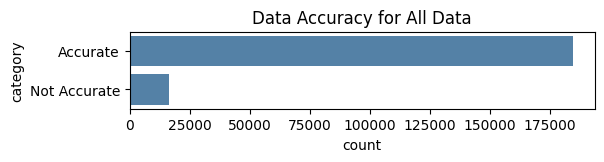

In [77]:
# Create a summary of the accuracy
df_pred_count = pd.DataFrame(df_news['pred_acc'].value_counts()).reset_index()
df_pred_count.columns = ['category', 'count']
dict_target_names = {False: 'Not Accurate', True: 'Accurate'}
df_pred_count['category'].replace(dict_target_names, inplace=True)
# Create a summary bar chart of categories
f = plt.figure(figsize=(6,1))
sns.barplot(x = 'count',
            y = 'category',
            data = df_pred_count,
            color = 'steelblue'
            ).set(title='Data Accuracy for All Data',)
plt.show()

In [75]:
# Dump the evaluation dataframe to a file
pickle.dump(df_news, open('%s/all_pred.p' % (EVAL_DIR), 'wb'))

In [ ]:
# Load the evaluation dataframe (if needed)
#df_news = pickle.load(open('%s/all_pred.p' % (EVAL_DIR))

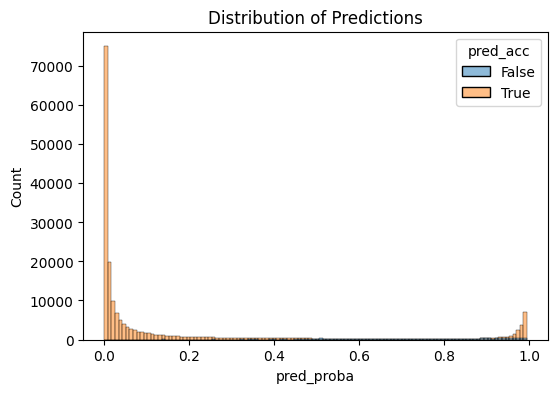

In [76]:
# Create a summary bar chart of predictions
f = plt.figure(figsize=(6,4))
sns.histplot(x = 'pred_proba',
            data = df_news,
            color = 'steelblue',
            hue = "pred_acc"
            ).set(title='Distribution of Predictions')
plt.show()

In [78]:
# Create a dataframe to focus only on wellness articles (subset)
df_news_target = df_news[df_news['wellness'] == 1]

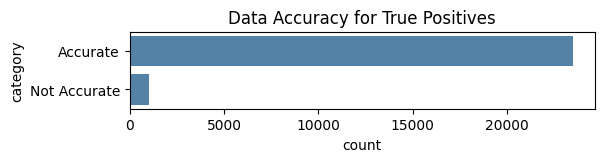

In [81]:
# Create a summary of the wellness predictions
df_pred_count = pd.DataFrame(df_news_target['pred_acc'].value_counts()).reset_index()
df_pred_count.columns = ['category', 'count']
dict_target_names = {False: 'Not Accurate', True: 'Accurate'}
df_pred_count['category'].replace(dict_target_names, inplace=True)
# Create a summary bar chart of categories
f = plt.figure(figsize=(6,1))
sns.barplot(x = 'count',
            y = 'category',
            data = df_pred_count,
            color = 'steelblue'
            ).set(title='Data Accuracy for True Positives',)
plt.show()

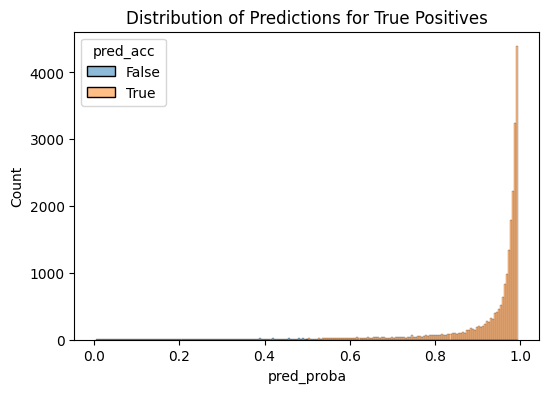

In [82]:
# Create a summary bar chart of true predictions
f = plt.figure(figsize=(6,4))
sns.histplot(x = 'pred_proba',
            data = df_news_target,
            color = 'steelblue',
            hue = "pred_acc"
            ).set(title='Distribution of Predictions for True Positives')
plt.show()

# 8.&nbsp; Results

The newly built model was able to meet and exceed expectations for the sensitivity (recall) of the model. It achieved a sensitivity 4% higher than the baseline (93% vs. 89%). Again, sensitivity is the true positive rate, or how often the prediction is correct, for actual positive values. By increasing this metric, the company can capture more websites aligned to their target customer base.


In addition, the metrics, including F1 Score, are all above 90% and exceeded the expected baseline metrics. This is a positive indicator that the model will satisfy the customers needs and drive improved customer success for their marketing campaign.

In [85]:
# Define numbers for results grid
Metric    = ['Recall', 'F1 Score', 'Specificity', 'Precision', 'Accuracy']
Baseline  = [.89, .87, None, .85, .86]
#New_Model = [.93, .92,  .92, .92, .92]
New_Model = [round(c_sensitivity,2), round(c_f1,2),  round(c_specificity,2), round(c_precision,2), round(c_accuracy,2)]
# Buildresults dataframe
dict_res = {'Metric': Metric, 'Baseline': Baseline, 'New Model': New_Model}
def_res = pd.DataFrame(dict_res)
def_res['% Improvement'] = def_res['New Model'] - def_res['Baseline']
# Display results
print('Final Model Results and Metrics', '\n')
def_res

Final Model Results and Metrics 



,Metric,Baseline,New Model,% Improvement
0,Recall,0.89,0.95,0.06
1,F1 Score,0.87,0.93,0.06
2,Specificity,NaN,0.91,NaN
3,Precision,0.85,0.91,0.06
4,Accuracy,0.86,0.93,0.07


# 9.&nbsp; References


*   [1] Module ktrain.text, https://amaiya.github.io/ktrain/text/index.html#ktrain.text.texts_from_df
*   [2] Package ktrain, https://amaiya.github.io/ktrain/index.html
*   [3] Module ktrain.predictor, https://amaiya.github.io/ktrain/predictor.html#ktrain.predictor.Predictor